In [1]:
! pip install datasets transformers

     |████████████████████████████████| 325 kB 4.2 MB/s 
     |████████████████████████████████| 4.0 MB 84.9 MB/s 
     |████████████████████████████████| 1.1 MB 82.0 MB/s 
     |████████████████████████████████| 77 kB 7.2 MB/s 
     |████████████████████████████████| 136 kB 101.2 MB/s 
     |████████████████████████████████| 212 kB 78.1 MB/s 
     |████████████████████████████████| 127 kB 83.8 MB/s 
     |████████████████████████████████| 6.6 MB 67.4 MB/s 
     |████████████████████████████████| 880 kB 76.6 MB/s 
     |████████████████████████████████| 596 kB 88.1 MB/s 
     |████████████████████████████████| 271 kB 72.0 MB/s 
     |████████████████████████████████| 144 kB 70.1 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=21925f6fb6c328f3064b9246d582c5e1277fed6cb8f9079bc13eaaca66cf0a07
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d6602

In [2]:
!pip install tf-models-official

     |████████████████████████████████| 2.2 MB 4.1 MB/s 
     |████████████████████████████████| 352 kB 72.4 MB/s 
     |████████████████████████████████| 636 kB 69.4 MB/s 
     |████████████████████████████████| 99 kB 12.2 MB/s 
     |████████████████████████████████| 237 kB 69.8 MB/s 
     |████████████████████████████████| 1.2 MB 66.5 MB/s 
     |████████████████████████████████| 90 kB 12.4 MB/s 
     |████████████████████████████████| 47.8 MB 1.1 MB/s 
     |████████████████████████████████| 1.1 MB 65.2 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 4.9 MB 42.4 MB/s 
     |████████████████████████████████| 462 kB 60.7 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=0481ff6fea7243d83145e2903817a20344445bb6102e2685c201c01fe5ae7189
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for seqeval: filename=seqeva

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May  8 10:50:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## Imports and variables

In [5]:
import pandas as pd
import json
import random
import numpy as np
import tensorflow as tf
import keras
import collections
from official.nlp import optimization


from datasets import load_dataset, load_metric, Dataset, DatasetDict, ClassLabel, Sequence, load_metric
from IPython.display import display, HTML
from transformers import AutoTokenizer, TFAutoModelForQuestionAnswering, DefaultDataCollator, create_optimizer, pipeline
from tqdm.auto import tqdm
from transformers.keras_callbacks import PushToHubCallback
from matplotlib import pyplot as plt

In [6]:
#!pip freeze > requirements.txt

In [7]:
model_checkpoint = "bert-base-cased"
#model_checkpoint = "xlnet-base-cased"
#model_checkpoint = "distilbert-base-uncased-distilled-squad"
#model_checkpoint = 'xlm-mlm-en-2048'
#model_checkpoint = 'distilbert-base-uncased'
#model_checkpoint = 'albert-base-v2'
#model_checkpoint = 'roberta-base'

#max_length = 384
#stride = 128
max_length = 448 # maximum length of input (max number of input tokens)
stride = 64 # overlapping tokens

n_best = 20
max_answer_length = 448 #200
predicted_answers = []
metric = load_metric("squad")

path_dictionary ='Slavka/xdzadi00_bert-based-v4'
#path_model = '/home/xsafon00/sdzadikova/model/xdzadi00_bert-based-v1.h5'
#path_model_config = '/home/xsafon00/sdzadikova/model/xdzadi00_bert-based-v1-config.json'
path_model_checkpoint = 'Slavka/checkpoint/xdzadi00_bert-based-v4'
#path_tokenizer = '/home/xsafon00/sdzadikova/model/tokenizer'
#path_tokenizer_vocab = '/home/xsafon00/sdzadikova/model/tokenizer'

In [8]:
from huggingface_hub import notebook_login

notebook_login()

# DATASET PREPARATION (load dataset)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load train and validation set, convert to Dataset type

with open('drive/MyDrive/Colab Notebooks/Resource/dataset_winlog_train.json', 'r') as file: #change path to real one
  train = json.load(file)

train_dataframe = pd.DataFrame.from_dict(train)
train_dataframe['answer'] = train_dataframe['answer'].astype('str') 
train_dataset = Dataset.from_pandas(train_dataframe)

with open('drive/MyDrive/Colab Notebooks/Resource/dataset_winlog_valid.json', 'r') as file: #change path to real one
  valid = json.load(file)

valid_dataframe = pd.DataFrame.from_dict(valid)
valid_dataframe['answer'] = valid_dataframe['answer'].astype('str') 
valid_dataset = Dataset.from_pandas(valid_dataframe)

datasets = DatasetDict({'train' : train_dataset, 'validation' : valid_dataset})

datasets

DatasetDict({
    train: Dataset({
        features: ['log_id', 'raw_data', 'question', 'question_id', 'answer', 'answer_start'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['log_id', 'raw_data', 'question', 'question_id', 'answer', 'answer_start'],
        num_rows: 10000
    })
})

In [ ]:
# beautified print of random element in Dataset 

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

display(HTML(pd.DataFrame(datasets['train'][:10]).to_html()))

# DATASET PREPROCESSING -- TOKENIZATION

In [ ]:
# set tokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [ ]:
# method for tokenization of training set

def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["raw_data"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answer"]

    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        start_char = examples["answer_start"][sample_idx]
        end_char = examples["answer_start"][sample_idx] + len(examples["answer"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [ ]:
# applying tokenization method to training dataset

train_dataset = datasets["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=datasets["train"].column_names,
)
len(datasets["train"]), len(train_dataset)

  0%|          | 0/30 [00:00<?, ?ba/s]

(30000, 85712)

In [ ]:
# method for tokenization of validation set

def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["raw_data"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["log_id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [ ]:
# applying tokenization method to validation dataset

validation_dataset = datasets["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=datasets["validation"].column_names,
)
len(datasets["validation"]), len(validation_dataset)

  0%|          | 0/10 [00:00<?, ?ba/s]

(10000, 28562)

# Methods for metrics computing -- applied after training



In [19]:
def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)

def get_gold_answers(example):
    """helper function that retrieves all possible true answers from a squad2.0 example"""
    
    #gold_answers = [answer["text"] for answer in example.answers if answer["text"]]
    gold_answers = [answer["text"] for answer in example.answers if answer["text"]]

    # if gold_answers doesn't exist it's because this is a negative example - 
    # the only correct answer is an empty string
    if not gold_answers:
        gold_answers = [""]
        
    return gold_answers

def compute(prediction_list, truth_list):
    match =[]
    f1 = []
    for i in range(len(prediction_list)):
      match.append(compute_exact_match(prediction_list[i], truth_list[i]))
      f1.append(compute_f1(prediction_list[i], truth_list[i]))

    count=0
    for r in match:
      count+=r
      match_perc = count/len(match)

    f=0
    for r in f1:
      f+=r
      f1_perc = f/len(f1)

    #return match, match_perc, f1, f1_perc
    print('Exact match: ', match_perc)
    print('F1: ', f1_perc)
    return match_perc, f1_perc

In [20]:
def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["log_id"]
        context = example["raw_data"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            #print('feature index', feature_index)
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()

            for start_index in start_indexes:
                for end_index in end_indexes:
                    #print('start index', start_index)
                    #print('end index', end_index)
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue
                    try:
                      answer = {
                          "text": context[offsets[start_index][0] : offsets[end_index][1]],
                          "logit_score": start_logit[start_index] + end_logit[end_index],
                      }
                      answers.append(answer)
                    except:
                      continue

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["log_id"], "answers": ex["answer"]} for ex in examples]

    prediction = [d['prediction_text'] for d in predicted_answers]
    theoretical = [d['answers'] for d in theoretical_answers]
    return compute(prediction, theoretical)
    #return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [21]:
class Save(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        model.save_pretrained(path_model_checkpoint+'/epoch-'+str(epoch+1))
        tokenizer.save_pretrained(path_model_checkpoint+'/epoch-'+str(epoch+1))

# FINE-TUNING the model

In [ ]:
model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

All model checkpoint layers were used when initializing TFBertForQuestionAnswering.

Some layers of TFBertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
data_collator = DefaultDataCollator(return_tensors="tf")

In [ ]:
tf_train_dataset = train_dataset.to_tf_dataset(
    columns=[
        "input_ids",
        "start_positions",
        "end_positions",
        "attention_mask",
        "token_type_ids",
    ],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=16,
)
tf_eval_dataset = validation_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask", "token_type_ids"],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=16,
)

In [ ]:
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_epochs = 4
num_train_steps = len(tf_train_dataset) * num_train_epochs


## ** OPTIMIZER **
#optimizer, schedule = create_optimizer(
#    init_lr=1e-6,
#    num_warmup_steps=0,
#    num_train_steps=num_train_steps,
#    weight_decay_rate=0.01,
#)
optimizer = optimization.create_optimizer(
    init_lr=1e-6,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_train_steps,
    optimizer_type='adamw'
    
)

model.compile(optimizer=optimizer)

# Train in mixed-precision float16
#tf.keras.mixed_precision.set_global_policy("mixed_float16")

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour, please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# learning process
#callback_save = Save()
#callbacks=[callback_save]

from transformers.keras_callbacks import PushToHubCallback

push_to_hub_callback = PushToHubCallback(
    output_dir=path_dictionary,
    tokenizer=tokenizer,
    hub_model_id=path_dictionary,
)

# Model weights are saved at the end of every epoch, if it's the best seen so far.
history = model.fit(tf_train_dataset, use_multiprocessing = True,epochs=num_train_epochs)

Cloning https://huggingface.co/Slavka/xdzadi00_bert-based-v4 into local empty directory.


Epoch 1/4
5357/5357 [==============================] - 4857s 903ms/step - loss: 3.6114
Epoch 2/4
5357/5357 [==============================] - 4836s 903ms/step - loss: 1.1350
Epoch 3/4
5357/5357 [==============================] - 4835s 903ms/step - loss: 0.3882
Epoch 4/4
5357/5357 [==============================] - 4836s 903ms/step - loss: 0.1558


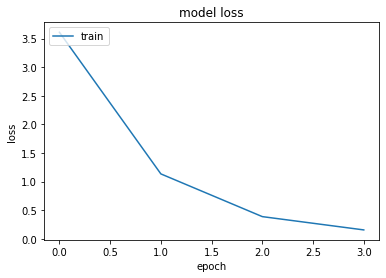

In [ ]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'val'], loc='upper left')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(tf_eval_dataset)

In [ ]:
#predictions = model.predict(tf_eval_dataset)
compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

  0%|          | 0/10000 [00:00<?, ?it/s]

Exact match:  0.5458
F1:  0.5441137502503226


(0.5458, 0.5441137502503226)

In [ ]:
# [for the real environment] ** SAVE AFTER EACH EPOCH **


#checkpoint_filepath = '/tmp/checkpoint'
#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#    filepath=checkpoint_filepath,
#    save_weights_only=True,
#    monitor='val_accuracy',
#    mode='max',
#    save_best_only=True)

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
#history = model.fit(tf_train_dataset, use_multiprocessing = True,epochs=num_train_epochs, callbacks=[model_checkpoint_callback])

In [ ]:
# save model to huggingface
#model.push_to_hub("Slavka/distil-bert-finetuned-log-parser-winlogbeat")
#model.push_to_hub("Slavka/bert-base-cased-finetuned-log-parser-winlogbeat_nowhitespace")
model.push_to_hub(path_dictionary)

Upload file tf_model.h5:   0%|          | 3.34k/411M [00:00<?, ?B/s]

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/Slavka/xdzadi00_bert-based-v4
   d7a4bbb..a3203f5  main -> main

remote: Allowed refs: all        
To https://huggingface.co/Slavka/xdzadi00_bert-based-v4
   d7a4bbb..a3203f5  main -> main



'https://huggingface.co/Slavka/xdzadi00_bert-based-v4/commit/a3203f53da1cef7e4adfed2d7e56b93e431a952d'

In [ ]:
# save tokenizer to huggingface
#tokenizer.push_to_hub("Slavka/distil-bert-finetuned-log-parser-winlogbeat")
#tokenizer.push_to_hub("Slavka/bert-base-cased-finetuned-log-parser-winlogbeat_nowhitespace")
tokenizer.push_to_hub(path_dictionary)

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/Slavka/xdzadi00_bert-based-v4
   a3203f5..dddae83  main -> main

remote: Allowed refs: all        
To https://huggingface.co/Slavka/xdzadi00_bert-based-v4
   a3203f5..dddae83  main -> main



'https://huggingface.co/Slavka/xdzadi00_bert-based-v4/commit/dddae83eba0d999fa857741d1fc4e77c5c2b0879'

In [ ]:
# [for the real environment] ** SAVE WEIGHTS and LOAD **


# Save the weights
#model.save_weights('./checkpoints/my_checkpoint')

# Restore the weights
#model.load_weights('./checkpoints/my_checkpoint')

# Load model as pipeline

In [9]:
test_model = TFAutoModelForQuestionAnswering.from_pretrained(path_dictionary)
test_tokenizer = AutoTokenizer.from_pretrained(path_dictionary)

Downloading:   0%|          | 0.00/643 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForQuestionAnswering.

All the layers of TFBertForQuestionAnswering were initialized from the model checkpoint at Slavka/xdzadi00_bert-based-v4.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.


Downloading:   0%|          | 0.00/320 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/654k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [26]:
with open('drive/MyDrive/Colab Notebooks/Resource/dataset_winlog_test.json', 'r') as file: #change path to real one
  test = json.load(file)

In [45]:
test_dataframe = pd.DataFrame.from_dict(test)
test_dataframe['answer'] = test_dataframe['answer'].astype('str') 

In [49]:
test_grouped = test_dataframe.groupby('question')

In [47]:
test_question_answerer = pipeline("question-answering", model=test_model, tokenizer=test_tokenizer, device=0)

#print(test_dataframe)
pred_all=[]
truth_all=[]

for x in test_grouped.groups:
    print("question:", x)
    group_x = test_grouped.get_group(x)
    pred_list = []
    truth_list =[]
    for index, row in group_x.iterrows():
        #print(row)
        result = test_question_answerer(question=str(row['question']), context=str(row['raw_data']))
        pred_list.append(result['answer'])
        truth_list.append(row['answer'])

        pred_all.append(result['answer'])
        truth_all.append(row['answer'])
    #print(pred_list)
    #print(truth_list)
    #print(group_x['question_id'], ': ',group_x['question'])
    compute(pred_list, truth_list)

question: What is IP address of DNS server?


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:703: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/pipelines/question_answering.py:300: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for span_id in range(num_spans)


Exact match:  0.0
F1:  0.0
question: What is PID of responsible process?
Exact match:  0.9774011299435028
F1:  0.9774011299435028
question: What is the event id (EventID or logid)?
Exact match:  0.9985141158989599
F1:  0.9985141158989599
question: What is the host's domain name?
Exact match:  0.9157088122605364
F1:  0.9157088122605364
question: What is the identification number of the origin user?
Exact match:  0.9483471074380165
F1:  0.9483471074380165
question: What is the identification number of the target user?
Exact match:  0.851063829787234
F1:  0.8516548463356974
question: What is the level of log?
Exact match:  0.9949494949494949
F1:  0.9949494949494949
question: What is the message of the event?
Exact match:  0.01375
F1:  0.022476806173152668
question: What is the name of the source host?
Exact match:  1.0
F1:  1.0
question: When did the event happen?
Exact match:  0.0
F1:  0.0
question: Which IP address is origin of the DNS event?
Exact match:  0.0
F1:  0.0
question: Which e

In [48]:
compute(pred_all, truth_all)

Exact match:  0.7245
F1:  0.7254198111605186


(0.7245, 0.7254198111605186)

In [ ]:
qa_model='Slavka/bert-base-cased-finetuned-log-parser-winlogbeat'
question_answerer = pipeline("question-answering", model=qa_model)

context = """
<Event xmlns='http://schemas.microsoft.com/win/2004/08/events/event'><System><Provider Name='Microsoft-Windows-Security-Auditing' Guid='{54849625-5478-4994-A5BA-3E3B0328C30D}'/><EventID>4662</EventID><Version>0</Version><Level>0</Level><Task>14080</Task><Opcode>0</Opcode><Keywords>0x8020000000000000</Keywords><TimeCreated SystemTime='2022-04-17T22:56:30.158528200Z'/><EventRecordID>826707</EventRecordID><Correlation ActivityID='{AC414243-50BD-0000-5F42-41ACBD50D801}'/><Execution ProcessID='576' ThreadID='776'/><Channel>Security</Channel><Computer>regina.vmware.fekt.cz</Computer><Security/></System><EventData><Data Name='SubjectUserSid'>S-1-5-18</Data><Data Name='SubjectUserName'>REGINA$</Data><Data Name='SubjectDomainName'>vmware</Data><Data Name='SubjectLogonId'>0x11b16c</Data><Data Name='ObjectServer'>DS</Data><Data Name='ObjectType'>%{19195a5b-6da0-11d0-afd3-00c04fd930c9}</Data><Data Name='ObjectName'>%{7d03dd58-23d3-45ea-b92b-5e0b943d94de}</Data><Data Name='OperationType'>Object Access</Data><Data Name='HandleId'>0x0</Data><Data Name='AccessList'>%%7688
				</Data><Data Name='AccessMask'>0x100</Data><Data Name='Properties'>%%7688
		{1131f6aa-9c07-11d1-f79f-00c04fc2dcd2}
	{19195a5b-6da0-11d0-afd3-00c04fd930c9}
</Data><Data Name='AdditionalInfo'>-</Data><Data Name='AdditionalInfo2'></Data></EventData><RenderingInfo Culture='en-US'><Message>An operation was performed on an object.

Subject :
	Security ID:		S-1-5-18
	Account Name:		REGINA$
	Account Domain:		vmware
	Logon ID:		0x11B16C

Object:
	Object Server:		DS
	Object Type:		%{19195a5b-6da0-11d0-afd3-00c04fd930c9}
	Object Name:		%{7d03dd58-23d3-45ea-b92b-5e0b943d94de}
	Handle ID:		0x0

Operation:
	Operation Type:		Object Access
	Accesses:		Control Access
				
	Access Mask:		0x100
	Properties:		Control Access
		{1131f6aa-9c07-11d1-f79f-00c04fc2dcd2}
	{19195a5b-6da0-11d0-afd3-00c04fd930c9}


Additional Information:
	Parameter 1:		-
	Parameter 2:		</Message><Level>Information</Level><Task>Directory Service Access</Task><Opcode>Info</Opcode><Channel>Security</Channel><Provider>Microsoft Windows security auditing.</Provider><Keywords><Keyword>Audit Success</Keyword></Keywords></RenderingInfo></Event>
  """
question = "What is the message of the event?"
question_answerer(question=question, context=context)

Downloading:   0%|          | 0.00/549 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/253M [00:00<?, ?B/s]

Some layers from the model checkpoint at Slavka/bert-base-cased-finetuned-log-parser-winlogbeat were not used when initializing TFDistilBertForQuestionAnswering: ['dropout_39']
- This IS expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForQuestionAnswering were not initialized from the model checkpoint at Slavka/bert-base-cased-finetuned-log-parser-winlogbeat and are newly initialized: ['dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/695k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:703: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/pipelines/question_answering.py:300: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for span_id in range(num_spans)


{'answer': 'SubjectLogonId',
 'end': 772,
 'score': 0.09700585156679153,
 'start': 758}

In [ ]:
question = "What is the message of the event?"
question_answerer(question=question, context=context)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:703: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/pipelines/question_answering.py:300: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for span_id in range(num_spans)


{'answer': 'SubjectLogonId',
 'end': 772,
 'score': 0.09700585156679153,
 'start': 758}